### TODO

- ✅ vectorize an input image matrix into a column vector
- ✅ compute the loss
- ✅ compute the accuracy
- ✅ compute the gradient of the model parameters with respect to the loss
- ✅ update the model parameters
- ✅ plot the results
- ✅ Apply the number of iterations that lead to the convergence of the algorithm (mini batch 256 vs batch gradient descent + larger learning rate)



### 1. Load training/validation image dataset

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

# define vectorize transformer
class VectorizeTransform:
    def __call__(self, img):
        return torch.reshape(img, (-1, ))

# compose image transformer
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    VectorizeTransform()    # for vectorizing input image
])

# load training dataset
train_data_path = './data/horse-or-human/train'
train_dataset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2048,
    shuffle=True,
    num_workers=0
)

# load validation dataset
valid_data_path = './data/horse-or-human/validation'
valid_dataset = torchvision.datasets.ImageFolder(root=valid_data_path, transform=transform)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=2048,
    shuffle=True,
    num_workers=0
)

### 2. Learning with the gradient descent in logistic regression

In [0]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def cost(y_pred, y):
    epsilon = 1e-12
    return -1 * (torch.mean(
        y * torch.log(y_pred + epsilon) + (1 - y) * torch.log(1 - y_pred + epsilon)
    ))

def accuracy(pred, actual):
    result = (pred > 0.5).float()
    return torch.mean((result == actual).float())

def forward(data_loader, w, b):
    data_count = len(data_loader.dataset)
    mean_loss = 0
    mean_acc = 0

    # for each mini batch of data
    for batch_idx, (x, y) in enumerate(data_loader):
        batch_size = x.shape[0] # get current batch size
        
        y = torch.reshape(y, (batch_size, 1)) # reshape y from [batch_size] to [batch_size, 1] 
        y_pred = sigmoid(torch.matmul(x, w.T) + b) # compute y^

        loss = cost(y_pred, y) # compute the loss 
        acc = accuracy(y_pred, y) # compute the accuracy

        mean_loss += batch_size * loss
        mean_acc += batch_size * acc

    mean_loss /= data_count
    mean_acc /= data_count

    return mean_loss, mean_acc

def backward(data_loader, w, b, lr):
    # for each mini batch of train data
    for batch_idx, (x_train, y_train) in enumerate(data_loader):
        batch_size = x_train.shape[0] # get current batch size
        
        y_train = torch.reshape(y_train, (batch_size, 1)) # reshape y_train from [batch_size] to [batch_size, 1] 
        y_pred_train = sigmoid(torch.matmul(x_train, w.T) + b) # compute y^

        # compute the gradient of the model parameters
        dw = (1 / batch_size) * torch.matmul((y_pred_train - y_train).T, x_train)
        db = (1 / batch_size) * torch.sum(y_pred_train - y_train)

        # update the model parameters
        w -= lr * dw
        b -= lr * db

    return w, b

def elapsed_time_in_milli(start_time):
    curr_time = datetime.datetime.now()
    return int((curr_time - start_time).total_seconds() * 1000)



In [0]:
import datetime

# get sample data for initializing parameters
it = iter(train_loader)
images, labels = it.next()

# initialize parameters
epoch_count = 5000
lr = 0.002
w = torch.zeros((1, images.shape[1]))
b = 0

train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

elapsed_times = []

# for each epoch
for epoch in range(epoch_count):
    start_time = datetime.datetime.now()

    # compute current epoch's loss and accuracy
    train_loss, train_acc = forward(train_loader, w, b)
    valid_loss, valid_acc = forward(valid_loader, w, b)

    # backward propagation: update model parameters
    w, b = backward(train_loader, w, b, lr)

    # append current epoch's elapsed time
    elapsed_times.append(elapsed_time_in_milli(start_time))

    # append current epoch's train loss and accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if epoch % 100 == 0:
      print(f'epoch: {epoch}')
      print(f'train loss: {train_loss}')
      print(f'train accuracy: {train_acc}')
      print(f'validation loss: {valid_loss}')
      print(f'validation accuracy: {valid_acc}\n\n')


epoch: 0
train loss: 0.693147599697113
train accuracy: 0.4868549108505249
validation loss: 0.6931471824645996
validation accuracy: 0.5


epoch: 100
train loss: 0.5279154777526855
train accuracy: 0.7643622159957886
validation loss: 0.4029311239719391
validation accuracy: 0.87109375


epoch: 200
train loss: 0.4771956503391266
train accuracy: 0.8003894686698914
validation loss: 0.3425810933113098
validation accuracy: 0.87109375


epoch: 300
train loss: 0.4464639127254486
train accuracy: 0.8140214085578918
validation loss: 0.32017508149147034
validation accuracy: 0.86328125


epoch: 400
train loss: 0.4238806962966919
train accuracy: 0.8305745124816895
validation loss: 0.3104656934738159
validation accuracy: 0.87109375


epoch: 500
train loss: 0.4058874845504761
train accuracy: 0.8442064523696899
validation loss: 0.3064970374107361
validation accuracy: 0.87109375


epoch: 600
train loss: 0.3909051716327667
train accuracy: 0.851996123790741
validation loss: 0.30555158853530884
validation acc

### 3. Plot the outputs

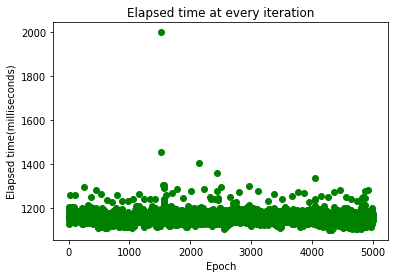

In [0]:
import matplotlib.pyplot as plt

# plot the elapsed time at every epoch
epoch_count = range(1, len(elapsed_times) + 1)
plt.title('Elapsed time at every iteration')
plt.scatter(epoch_count, elapsed_times, c='g')
plt.xlabel('Epoch')
plt.ylabel('Elapsed time(milliseconds)')
plt.show()


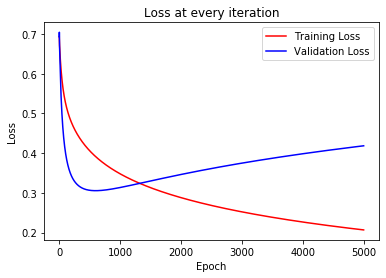

In [0]:
# plot the training and validation loss at every epoch
epoch_count = range(1, len(train_losses) + 1)
plt.title('Loss at every iteration')
plt.plot(epoch_count, train_losses, 'r-')
plt.plot(epoch_count, valid_losses, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


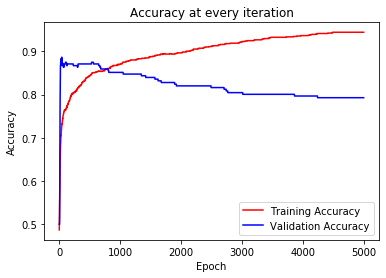

In [0]:
# plot the training and validation accuracy at every epoch
epoch_count = range(1, len(train_accs) + 1)
plt.title('Accuracy at every iteration')
plt.plot(epoch_count, train_accs, 'r-')
plt.plot(epoch_count, valid_accs, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [0]:
import plotly.graph_objects as go

# present the table for the final result
fig = go.Figure(
    data=[go.Table(header=dict(values=['<b>dataset</b>', '<b>loss</b>', '<b>accuracy</b>']),
    cells=dict(values=[['training', 'validation'], [train_losses[-1], valid_losses[-1]], [train_accs[-1], valid_accs[-1]]]))]
)
fig.show()
